# Self-Driving Lab Demo

<a target="_blank" href="https://colab.research.google.com/github/emdgroup/baybe-resources/blob/main/notebooks/SDL_workshop.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Welcome to the lightmixing self-driving lab! The following code lets you run the SDL-Demo remotely from your browser! You can execute each cell individually by clicking the play button ▶️ on the left or using `Shift` + `Enter`.

This tutorial is divided into three parts:

1. **Getting Started:**  
   Learn the basics—how to control the LED, read sensor data, and define the target spectrum.

2. **Running Different Search Algorithms:**  
   Explore how traditional methods (grid search, random search, and Latin hypercube sampling) and Bayesian optimization via BayBE drive the self-driving lab.

3. **Optional Advaned Usage of BayBE:**  
   Discover how Bayesian optimization with BayBE can be done in advanced scenarios such as multiple targets or transfer learning.

> 💡**Note:** Click the first tab (Table of Contents) to see the notebook's structure. We recommend running all cells from top to bottom due to interdependencies.

# Contributors
- Sterling G. Baird
- Viola Muning Li
- Shaoming Zhang
- Martin Fitzer

# Setup and Preparation

## Installation

To get started, we first install the `self_driving_lab_demo` and `baybe` packages. This will set up everything needed to run the demo.

> ⏳ **Note:** The installation may take a few minutes. You can click the small **arrow 🔽** next to this section title to **collapse the output** once it finishes.

In [ ]:
#%pip install git+https://github.com/sparks-baird/self-driving-lab-demo.git git+https://github.com/emdgroup/baybe.git matplotlib plotly # would use latest versions from github
%pip install self-driving-lab-demo baybe==0.14.2 matplotlib

## Target Spectrum

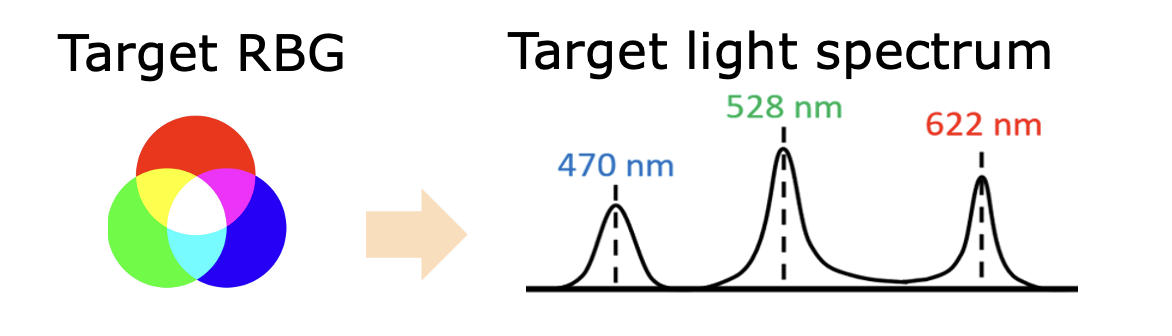

Let's start by setting up the target spectrum. Our overall final goal is to use optimization to find the RGB values that match this target. We do this in two steps:

1. **Create the SelfDrivingLabDemo Instance:**  
   This object connects to the hardware using MQTT. It sends your chosen RGB values to the microcontroller and then receives the sensor data in return.  
   - **What to do:** Enter your **PICO_ID**. If you don’t have a device, just type `"test"`.  
   - (The session ID is handled automatically.)

2. **Define the Target Spectrum:**  
   We define the target by setting specific RGB values to light up the LED. The sensor then measures the light in **eight channels** under these conditions. These eight measurements form our target spectrum.  
   - Later, we’ll use optimization to find the RGB values that make the new sensor measurements match this target spectrum as closely as possible.

> ⚠️ **Warning:** The measured target also includes ambient background light. For best results, avoid moving the Raspberry Pi or changing surrounding light conditions during the experiment.

In [ ]:
from uuid import uuid4  # universally unique identifier
from self_driving_lab_demo import (
    SelfDrivingLabDemoLight,
    mqtt_observe_sensor_data,
    get_paho_client,
)
import numpy as np

# Overwrite this PICO_ID with the one you get when starting your SDL kit
PICO_ID = "test"  # @param {type:"string"}

dummy = False  # @param {type:"boolean"}
log_to_database = False  # @param {type:"boolean"}
SESSION_ID = str(uuid4())  # random session ID
print(f"session ID: {SESSION_ID}")
rng = np.random.default_rng()  # random number generator

# You can change the values below to set the target color (keep below 89, 255 is very bright)
R_target = 75  # @param {type:"integer"}
G_target = 10  # @param {type:"integer"}
B_target = 56  # @param {type:"integer"}

target_inputs = {"R": R_target, "G": G_target, "B": B_target}

# instantiate client once and reuse (to avoid opening too many connections)
client = get_paho_client(
    f"sdl-demo/picow/{PICO_ID}/as7341/",
    username="sgbaird",
    password="D.Pq5gYtejYbU#L",
    hostname="248cc294c37642359297f75b7b023374.s2.eu.hivemq.cloud",
)

sdl = SelfDrivingLabDemoLight(
    autoload=True,  # perform target data experiment automatically
    target_inputs=target_inputs,  # if None, then defaults to random color using `target_seed` attribute
    random_rng=rng,
    target_seed=604523,  # change to get different random target color (if `target_inputs` is None)
    simulation=dummy,  # run simulation instead of physical experiment
    observe_sensor_data_fn=mqtt_observe_sensor_data,  # (default)
    observe_sensor_data_kwargs=dict(
        pico_id=PICO_ID,
        session_id=SESSION_ID,
        client=client,
        mongodb=log_to_database,
    ),
)

The sensor measures light at eight different wavelengths, from about 410 nm to 670 nm. Each channel roughly corresponds to a color band in the visible spectrum, as shown below. When we set a target spectrum, we aim to match these channel intensities during optimization.

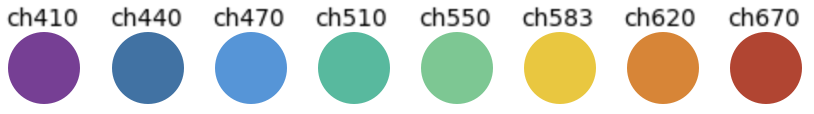

In [ ]:
target_data = {k: sdl.target_results[k] for k in sdl.channel_names}
target_data

In [ ]:
import matplotlib.pyplot as plt

wavelengths = list(target_data.keys())
intensities = list(target_data.values())

fig, ax = plt.subplots(figsize=[6, 3])
ax.scatter(wavelengths, intensities, color="blue", s=100)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Intensity")
plt.show()

## LED Control & Sensor Measurement

In the previous section, we defined the target spectrum using preset RGB values. Now, we mimic the actual experiment by controlling the LED and reading the sensor data.

Here's what happens in this cell:
- **Send Commands:** We input new RGB values.
- **Control LED:** The microcontroller briefly turns on the LED with these settings.
- **Measure Data:** The spectrophotometer collects the light data across eight channels.
- **Data Relay:** This data is published to the HiveMQ MQTT server, which acts as a bridge between the microcontroller and this notebook.

This cell demonstrates the complete cycle—from setting an RGB value to receiving the sensor measurement—just like in a real experiment.

In [ ]:
# You can change the values below to set the color
# (keep below 89, 255 is very bright)
R = 30  # @param {type:"integer"}
G = 60  # @param {type:"integer"}
B = 25  # @param {type:"integer"}

measured_data = sdl.observe_sensor_data({"R": R, "G": G, "B": B})
measured_data = {k: measured_data[k] for k in sdl.channel_names}
measured_data

## Optimization Objective: Error Minimization

For every optimization method, we need an objective function that tells us how close our current measurement is to the target. In our case, the goal is to have the measured spectrum as similar as possible to the target spectrum.

To achieve this, we use the **Mean Absolute Error (MAE)** as our error metric. The MAE calculates the average of the absolute differences between the measured and target values. In mathematical terms:

$$
\mathrm{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - x_i \right|
$$

where:
- $y_i$ is the measured value for channel $n$,
- $x_i$ is the target value for channel $n$,
- $n$ is the total number of channels (in our case, $n=8$).

**Our Optimization Objective:**  
We aim to **minimize** this MAE. A lower MAE means that the measured spectrum is closer to the target, which is exactly what we want from the optimization process. This error metric drives the optimization algorithms to adjust the RGB values so that the resulting measurements best match our target spectrum.

> 💡**Note**: Other objective functions (such as the desirability, the RMSE or the Frechet distance) can also be used, depending on your experiment's needs.

In [ ]:
import matplotlib.pyplot as plt

wavelengths_target = list(target_data.keys())
intensities_target = list(target_data.values())

wavelengths_measured = list(measured_data.keys())
intensities_measured = list(measured_data.values())

fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(wavelengths_target, intensities_target, color='blue', s=100, label="Target")
ax.scatter(wavelengths_measured, intensities_measured, color='red', s=100, label="Measured")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Intensity")
ax.legend()

plt.show()

You can see that the measured spectrum does not closely resemble the target spectrum. We can express this mismatch in the RMSE as single number, which becomes our minimization target in the optimization campaigns further below.

In [ ]:
import numpy as np

number_of_channels = 8

def mean_absolute_error(target_data, measured_data):
    target_data_array = np.asarray(list(target_data.values()))
    measured_data_array = np.asarray(list(measured_data.values()))
    abs_diff = np.abs(np.subtract(target_data_array, measured_data_array))
    diff_sum = np.sum(abs_diff)
    mae = diff_sum / number_of_channels
    return mae

mean_absolute_error(target_data, measured_data)

# Running Different Search Algorithms

We want to systematically explore the parameter space to find the **optimal RGB settings** that match our **target spectrum**—this is essentially a **Design of Experiments (DOE)** approach.

We define a range for the **R, G, and B** values, while leaving the sensor parameters (`atime`, `astep`, `gain`) **fixed**.

> ⚠️ **Warning:** The RGB values are capped to 35% power (since 100% power can be even more painful to look at).

In [ ]:
sdl.bounds

To streamline this process, we’ve wrapped everything in a single function `evaluate` that:
1. Takes a point `(R, G, B)` from the search domain
2. Sends these values to the hardware
3. Measures the resulting spectrum
4. Calculates the **MAE**
5. Logs the result for analysis

In [ ]:
def evaluate(sdl, point):
    measured_data = sdl.observe_sensor_data(point)

    target_data = {k: sdl.target_results[k] for k in sdl.channel_names}
    measured_data = {k: measured_data[k] for k in sdl.channel_names}

    mae = mean_absolute_error(target_data, measured_data)

    measured_data["mae"] = mae

    return measured_data

In [ ]:
evaluate(sdl, {"R": R, "G": G, "B": B})

To drive the experiment forward (and of course, make it "self-driving" 🚀), we need an optimization algorithm to choose the next RGB values.

In this first part, we explore three basic methods:

1. **Grid Search:**  
  Evaluates every combination on a fixed grid over the RGB space.
  
  For example, using 3 values per channel means testing `3×3×3 = 27` combinations.

2. **Random Search:**  
  Randomly selects RGB values within the allowed range. This method is less systematic but can sometimes quickly find good solutions.

3. **Latin Hypercube Sampling (LHS):**  
  Divides each channel’s range into equal intervals and samples from each. This ensures a well-distributed exploration of the RGB space.

Let’s start by testing these basic methods before moving on to the more advanced Bayesian approach.

In [ ]:
num_iter = 27 # @param {type:"integer"}

> ⚠️ **Warning**: `num_iter` must be a cubic number due to the grid search.

> ⏱️ **Note**: One iteration takes around 2 seconds with the hardware and 6 seconds without hardware. Balance your iteration count with the accuracy accordingly for a smoother experiment.

## Grid Search

Grid search exhaustively tests every combination of parameters by constructing a grid based on your chosen discretization. It’s straightforward and works well in low dimensions, but its computational cost grows rapidly in larger spaces. In the DOE community the grid with 3 points per parameter is also kown as full-factorial DOE.

> 💡**Note:** For a fair comparison, ensure that the target color does not exactly fall on a grid point. If this is the case the results for grid search will look great but this is not representative since in a general practical application the optimum will not fall onto one of the grid points

Let's now define the grid search function, which constructs the grid and evaluates the measured data at each grid point.

In [ ]:
from sklearn.model_selection import ParameterGrid

def grid_search(sdl, num_iter):

    # Define the grid points
    param_grid = {}
    parameters = dict(R=sdl.bounds["R"], G=sdl.bounds["G"], B=sdl.bounds["B"])
    num_pts_per_dim = int(np.floor(num_iter ** (1 / len(parameters))))
    for name, bnd in parameters.items():
        param_grid[name] = np.linspace(bnd[0], bnd[1], num=num_pts_per_dim)
        param_grid[name] = np.round(param_grid[name]).astype(int)
    grid_inputs = list(ParameterGrid(param_grid))

    # Get measured data and error for each grid point
    grid_data = []
    for idpt, pt in enumerate(grid_inputs):
        print(f"{idpt+1}.iteration:", pt)
        grid_data.append(evaluate(sdl, pt))

    return grid_inputs, grid_data

The following cell starts the grid search algorithm.

In [ ]:
%%time
grid_inputs, grid_data = grid_search(sdl, num_iter)

**Observed Points and Corresponding Errors**

Let's take a look at the points observed for the grid search algorithm. The axes correspond to the `(R, G, B)` input values, while the color indicates the MAE.

The MAE shows how close the measured spectrum is to the target spectrum—lower values are better, with zero indicating a perfect match.

> 💡**Note:** If the plot renders successfully, you can zoom in and out and hover over each point to see its corresponding RGB.

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

grid_input_df = pd.DataFrame(grid_inputs)
grid_output_df = pd.DataFrame(grid_data)[["mae"]]
grid_df = pd.concat([grid_input_df, grid_output_df], axis=1)
grid_df["best_so_far"] = grid_df["mae"].cummin()
px.scatter_3d(
    grid_df,
    x="R",
    y="G",
    z="B",
    color="mae",
    title="Grid search",
    width=550,
    height=550,
).update_layout(scene_camera_eye=dict(x=1.45, y=1.45, z=1.45))

The best result has an error of

In [ ]:
grid_df["best_so_far"].iloc[-1]

## Random Search

Random search picks parameter values at random from the allowed ranges instead of trying every combination. This method provides a broader exploration with fewer iterations, making it especially useful for high-dimensional spaces. While it may miss some optimal combinations due to its randomness, it offers a good balance between computation time and performance in our experiments.

In [ ]:
def random_search(sdl, num_iter):

    # Get a random color in the search space
    def get_random_color(sdl):
        rng = sdl.random_rng
        # 1.0 is really bright, so no more than `max_power`
        RGB = 255 * rng.random(3) * sdl.max_power
        R, G, B = np.round(RGB).astype(int)
        return dict(R=int(R), G=int(G), B=int(B))

    # Get a random sample point and evaluate this point for num_iter iterations
    random_inputs = []
    random_data = []
    for i in range(num_iter):
        pt = get_random_color(sdl)
        print(f"{i+1}.iteration:", pt)
        random_inputs.append(pt)
        random_data.append(evaluate(sdl, pt))

    return random_inputs, random_data

In [ ]:
random_inputs, random_data = random_search(sdl, num_iter)

**Observed Points and Corresponding Errors**

In [ ]:
random_input_df = pd.DataFrame(random_inputs)
random_output_df = pd.DataFrame(random_data)[["mae"]]
random_df = pd.concat([random_input_df, random_output_df], axis=1)
random_df["best_so_far"] = random_df["mae"].cummin()

px.scatter_3d(
    random_df,
    x="R",
    y="G",
    z="B",
    color="mae",
    title="Random Search",
    width=550,
    height=550,
).update_layout(scene_camera_eye=dict(x=1.45, y=1.45, z=1.45))

In [ ]:
random_df["best_so_far"].iloc[-1]

## Latin Hypercube Sampling

Latin hypercube sampling (LHS) improves the uniformity of random sampling. Instead of picking points completely at random, the parameter space is divided into equal intervals. Then, one point is randomly selected within each interval, ensuring every part of the space is covered more evenly. This approach results in lower discrepancy compared to standard random search.

In [ ]:
from re import I
from scipy.stats import qmc

def lhs(sdl, num_iter):

    # Get all LHS samples
    sampler = qmc.LatinHypercube(d=3, optimization="random-cd")
    samples = sampler.random(num_iter)
    l_bounds = [sdl.bounds["R"][0], sdl.bounds["G"][0], sdl.bounds["B"][0]]
    u_bounds = [sdl.bounds["R"][1], sdl.bounds["G"][1], sdl.bounds["B"][1]]
    samples = qmc.scale(samples, l_bounds, u_bounds)
    lhs_inputs = [dict(R=int(sample[0]), G=int(sample[1]), B=int(sample[2]))
                  for sample in samples]

    # Get measured data and error for each sample point
    lhs_data = []
    for idpt, pt in enumerate(lhs_inputs):
        print(f"{idpt+1}.iteration:", pt)
        lhs_data.append(evaluate(sdl, pt))
    return lhs_inputs, lhs_data

In [ ]:
lhs_inputs, lhs_data = lhs(sdl, num_iter)

**Observed points and corresponding errors**

In [ ]:
lhs_input_df = pd.DataFrame(lhs_inputs)
lhs_output_df = pd.DataFrame(lhs_data)[["mae"]]
lhs_df = pd.concat([lhs_input_df, lhs_output_df], axis=1)
lhs_df["best_so_far"] = lhs_df["mae"].cummin()
px.scatter_3d(
    lhs_df,
    x="R",
    y="G",
    z="B",
    color="mae",
    title="Latin hypercube sampling",
    width=550,
    height=550,
).update_layout(scene_camera_eye=dict(x=1.45, y=1.45, z=1.45))

In [ ]:
lhs_df["best_so_far"].iloc[-1]

## Bayesian Optimization

Unlike the previous methods, Bayesian optimization (BO) *learns* from past results to decide what to try next: It builds a model of the error between the measured and target RGB spectrum and uses that to pick the next LED settings. This helps avoid poor combinations and focus on promising ones. It’s especially useful here, since each experiment (turning on the LED, reading the spectrum) takes time — and we want to find the best mix with as few tries as possible.

We will use [BayBE](https://github.com/emdgroup/baybe), a general-purpose toolbox for Bayesian Design of Experiments. Let's first install the latest version.

The diagram below shows what components to run BO come together in BayBE. For this demo you need only very few aspects of this and we will use standard settings.

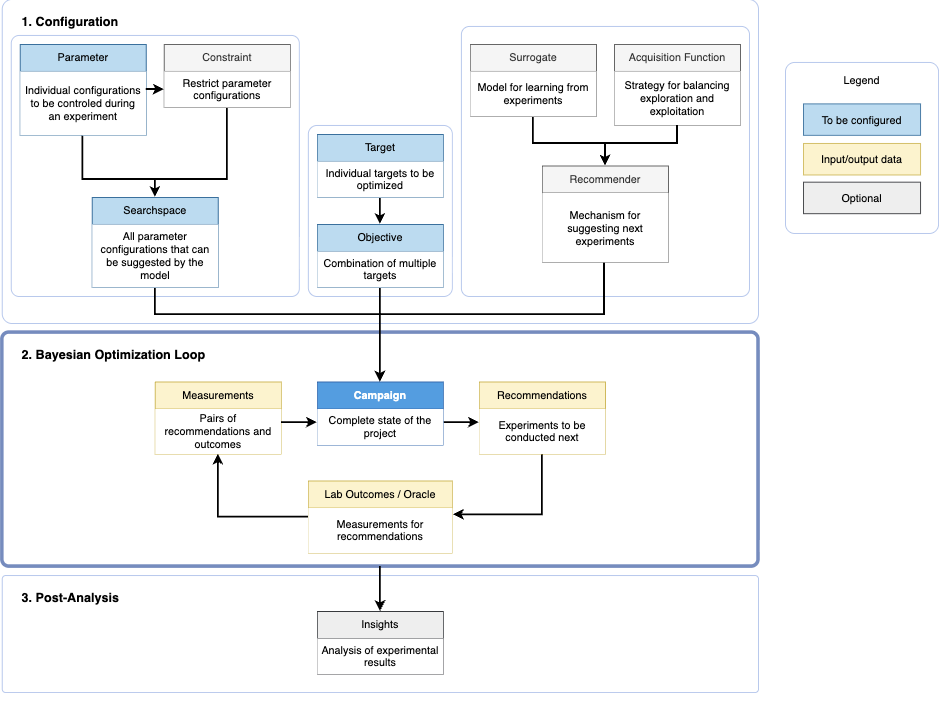

### 1. Configuration

Before we can start the optimization, we need to **configure a `Campaign`**.

A `Campaign` in BayBE is the central object that holds everything needed for the experiment: parameters, objective, search space, and recommender. It also tracks all measurements and recommendations throughout the run.

In the following steps, we’ll define the individual parts of the campaign:

1. **Objective** – what we want to optimize  
2. **Parameters & Search Space** – which inputs we control and their allowed ranges  
3. **Recommender** – for this demo we will use the default which is achieved by not specifying the recommender at all

Once these are in place, we can initialize the campaign and start the optimization loop.

First, we need to define the **objective function** for the optimization.  
In BayBE, an objective can include multiple targets—like yield, temperature, or pressure in a lab experiment. But in our case, we have only **one** target: the **mean absolute error (MAE)** between the measured spectrum and the predefined target spectrum. This single-target objective will guide the optimization process.

In [ ]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective

target = NumericalTarget(name="mae", minimize=True)
objective = SingleTargetObjective(target=target)

Next, we specify the **parameters** and define the search space.  
In our case, the parameters are the **R, G, and B** values that control the LED intensities. We define a **continuous search space** for each channel, allowing BayBE to explore a wide range of values. Before sending these values to the microcontroller, we **round them to integers**, since the hardware only accepts discrete input levels.

> 💡 **Note**: Instead of the `NumericalContinuousParameter` you could also use the `NumericalDiscreteParameter` which only allows a discrete set of choices

In [ ]:
from baybe.parameters import NumericalContinuousParameter

parameters = [
    NumericalContinuousParameter(
        name="R",
        bounds=(sdl.bounds["R"][0], sdl.bounds["R"][1]),
    ),
    NumericalContinuousParameter(
        name="G",
        bounds=(sdl.bounds["G"][0], sdl.bounds["G"][1]),
    ),
    NumericalContinuousParameter(
        name="B",
        bounds=(sdl.bounds["B"][0], sdl.bounds["B"][1]),
    ),
]

In [ ]:
from baybe.searchspace import SearchSpace

searchspace = SearchSpace.from_product(parameters)

### 2. Self-Driving Optimization Loop

Now we define the **main optimization loop**. This is where the campaign interacts with both the optimizer and the lab hardware.

In each iteration:

1. The **recommender** suggests a new set of **RGB values** to try
2. These values are sent to the microcontroller, which turns on the LED and measures the resulting spectrum  
3. We compute the **mean absolute error (MAE)** between the measured and target spectrum  
4. This result is recorded as a new **measurement** in the campaign
5. We start again from step 1

With BayBE, this loop is fully automated:  
New suggestions are based on all past measurements, and the campaign keeps track of the full optimization history.

Let's define the main iteration loop as a wrapper function:

In [ ]:
def bayesian(sdl, campaign, num_iter):

    for i in range(num_iter):
        df = campaign.recommend(batch_size=1).astype(int)
        df_entry = df.iloc[0]
        df_entry_dict = dict(R=df_entry['R'], G=df_entry['G'], B=df_entry['B'])
        print(f"{i+1}.iteration:", df_entry_dict)
        data = evaluate(sdl, df_entry_dict)
        df["mae"] = data["mae"]
        campaign.add_measurements(df.astype(float))

    return campaign

In [ ]:
from baybe import Campaign

campaign = Campaign(searchspace, objective)
campaign = bayesian(sdl, campaign, num_iter)

### 3. Post-analysis: Observed Points and Corresponding Errors

In [ ]:
bayesian_df = campaign.measurements.copy()
bayesian_df["best_so_far"] = bayesian_df["mae"].cummin()
px.scatter_3d(
    bayesian_df,
    x="R",
    y="G",
    z="B",
    color="mae",
    title="Bayesian optimization",
    width=550,
    height=550,
).update_layout(scene_camera_eye=dict(x=1.45, y=1.45, z=1.45))

In [ ]:
bayesian_df["best_so_far"].iloc[-1]

Let's store the result of this campaign in another variable for later use in the optional Tranfer Learning task.

**Note: The variable `bayesian_df_tl_old` should not be modified or overwritten.**

In [ ]:
bayesian_df_tl_old = bayesian_df.copy()

## Comparison of Methods

The table below summarizes how each method performs in theory.

| Feature           | Grid / Random / LHS Search                              | Bayesian Optimization                          |
|------------------|----------------------------------------------------|------------------------------------------------|
| **Exploration**   | Blind or uniform search without learning           | Adaptive search guided by a probabilistic model |
| **Exploitation**  | None - no learning from previous results           | Actively focuses on promising regions           |
| **Efficiency**    | Low, but typically LHS > RS > GS                          | High - fewer trials, smarter choices            |
| **Scalability**   | Poor to moderate with many parameters              | High - well suited for complex problems         |

First, lets get an impression of the best (lowest) error each method has produced. This is a direct ranking of how well the methods utilized the experimental budget of `num_iter` iterations

In [ ]:
for k, df in enumerate([grid_df, random_df, lhs_df, bayesian_df]):
    plt.bar(k, df["best_so_far"].iloc[-1]);
plt.legend(['Grid Search','Random','Latin Hypercube','BayBE']);
plt.title(f"MAE of best point after {num_iter} iterations (smaller is better)");

Now let’s compare the actual performance of all four methods in our RGB optimization task. We will use a completely shared color axis which is cutoff at a value of 5000. This will make it clear which algorthm prouces better (darker) points.

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# Shared color range
cmin, cmax = 0, 5000

fig = make_subplots(
    rows=1, cols=4,
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=("Grid Search", "Random", "Latin Hypercube", "BayBE"),
)

dfs = [grid_df, random_df, lhs_df, bayesian_df]
for k, df in enumerate(dfs, start=1):
    fig.add_trace(
        go.Scatter3d(
            x=df["R"], y=df["G"], z=df["B"],
            mode="markers",
            marker=dict(
                color=df["mae"],
                colorscale="Viridis",
                cmin=cmin,
                cmax=cmax,
                coloraxis="coloraxis",
            ),
            showlegend=False,
        ),
        row=1, col=k,
    )

# Shared camera
camera = dict(eye=dict(x=2.1, y=2.1, z=2.1), )
for k in range(1, 5):
    fig.layout[f"scene{k}"].camera = camera

# Define shared coloraxis
fig.update_layout(
    coloraxis=dict(
        colorscale="Viridis",
        cmin=cmin,
        cmax=cmax,
        colorbar=dict(title="MAE"),
    ),
    height=550, width=1350,
    title_text="Different Strategies for Experimental Design",
)

fig.show()

We'll plot how the MAE changes as a function of the number of iterations.
The faster the error decreases, the better the method performs.

> 💡 **Note**: For **Grid Search** and **Latin Hypercube Sampling**, all sampling points are generated upfront. So unlike the Bayesian or random method, these algorithms do not provide you with an optimization trajectory, just a plan of **num_iter** points that is always the same. This, however, can give the wrong impression in a plot of the kind that we will see below, which shows the optimziation trajectory and hence the specific order the points were meausred. For methods that do not have a well defined trajectory, we "act" like we get a trajectory by randomly permuting the recommended points. To average out the effect of randomness we create 20 of these permutations and plot the average trajectory. This procedure is known as Monte-Carlo (MC) backtesting and we can use it for a fair comparison of the methods. Strictly speaking, we also need to repeat the BayBE and random method 20 times for a fair comparison. However, unlike in the other methods, we cant just permute the result, because the BayBE and random trajectories are always different and not created once in the beginning. So 20 independent trajectories would have to be measured. Since this takes too long we will only show 1 trajectory for BayBE and random. The optional section "Average Performace" deals with repeating more trajectories.

In [ ]:
import seaborn as sns

result = []
for df, name in zip(dfs, ["Grid Search", "Random", "Latin Hypercube", "BayBE"]):
    df['mc_run'] = 0
    df['method'] = name
    df["iteration"] = df.index + 1
    result.append(df)
    
    if name in ['Random', 'BayBE']: # dont create permutations for the BayBE method
        continue 
            
    for k in range(1,20):
        df_ = df.sample(frac=1.0) # this creates a copy of df with randomly permuted rows
        df_['mc_run'] = k
        
        # We need to recaclulate the iteration and the cumulative min (best_so_far)
        # because the permutation 
        df_["iteration"] = df.index + 1 
        df_['best_so_far'] = df_['mae'].cummin()
        
        result.append(df_)

result = pd.concat(result)

In [ ]:
sns.lineplot(result, x='iteration', y='best_so_far', hue='method');
plt.title('Method Comparison via Backtest (lower and earlier is better)');

We can see two very important results in this plot:
* The BO algorithm reaches a much lower minimum, which means a better experimental result
* The BO algorithm reaches lower values at earlier iterations, which means you can actually stop the optimization earlier while keeping a good result

Let's take a look how close the best experiments from each algorithm compare to the true target inputs.

In [ ]:
true_inputs = pd.DataFrame(
    {key: sdl.get_target_inputs()[key] for key in sdl.get_target_inputs()},
    index=[0],
)
true_inputs["method"] = "True Optimum"

grid_df["method"] = "Grid Search"
lhs_df["method"] = "Latin Hypercube"
best_grid_inputs = grid_df.iloc[grid_df["mae"].idxmin()][
    ["R", "G", "B", "method"]
]
best_random_inputs = random_df.iloc[random_df["mae"].idxmin()][
    ["R", "G", "B", "method"]
]
best_lhs_inputs = lhs_df.iloc[lhs_df["mae"].idxmin()][["R", "G", "B", "method"]]
best_bayesian_inputs = bayesian_df.iloc[bayesian_df["mae"].idxmin()][
    ["R", "G", "B", "method"]
]

best_df = pd.concat([
    best_grid_inputs,
    best_random_inputs,
    best_lhs_inputs,
    best_bayesian_inputs,
], axis=1).T
best_df = pd.concat([best_df, true_inputs], axis=0)

fig = px.scatter_3d(
    best_df,
    x="R",
    y="G",
    z="B",
    color="method",
    title="Best results",
    width=550,
    height=550,
).update_layout(
    scene=dict(
        xaxis=dict(
            nticks=4,
            range=[sdl.bounds["R"][0], sdl.bounds["R"][1]],
        ),
        yaxis=dict(
            nticks=4,
            range=[sdl.bounds["G"][0], sdl.bounds["G"][1]],
        ),
        zaxis=dict(
            nticks=4,
            range=[sdl.bounds["B"][0], sdl.bounds["B"][1]],
        ),
        aspectmode="cube"
    ),
    scene_camera_eye=dict(x=1.6, y=1.6, z=1.6),
)
fig.data[-1].marker.symbol = "diamond-open"
fig.show()

# Optional: Average Performance

The performance of the different methods depend on many factors and are highly volatile due to the simplicity of the problem and the random nature of some processes. To make a fair comparison between the methods, it's best if we look at the average behavior across multiple runs or campaigns.

> ⚠️ **Warning**: The following cells will take approx. 25-30 minutes to run! You could run

In [ ]:
num_repeats = 4 # @param {type:"integer"}

In [ ]:
bayesian_avg_dfs = []
for i in range(num_repeats):
    print(f"... Repeat number {i+1}")
    campaign_avg = Campaign(searchspace, objective)
    campaign_avg = bayesian(sdl, campaign_avg, num_iter)
    bayesian_avg_df = campaign_avg.measurements.copy()
    bayesian_avg_df["best_so_far"] = bayesian_avg_df["mae"].cummin()
    bayesian_avg_dfs.append(bayesian_avg_df)

In [ ]:
random_avg_dfs = []
for k in range(num_repeats):
    print(f"... Repeat number {k+1}")
    random_avg_inputs, random_avg_data = random_search(sdl, num_iter)
    random_avg_input_df = pd.DataFrame(random_avg_inputs)
    random_avg_output_df = pd.DataFrame(random_avg_data)[["mae"]]
    random_avg_df = pd.concat(
        [random_avg_input_df, random_avg_output_df],
        axis=1,
    )
    random_avg_df["best_so_far"] = random_avg_df["mae"].cummin()
    random_avg_dfs.append(random_avg_df)


In [ ]:
from self_driving_lab_demo.utils.plotting import line

bayes_best_objs = [bayesian_avg_df["best_so_far"]
                   for bayesian_avg_df in bayesian_avg_dfs]
bayes_mean = np.mean(bayes_best_objs, axis=0)
bayes_std = np.std(bayes_best_objs, axis=0)

bayes_line_df = pd.DataFrame(
    dict(
      iteration=bayesian_avg_dfs[0]["BatchNr"],
      mean=bayes_mean,
      std=bayes_std,
    )
)
bayes_line_df["method"] = "bayesian"

random_best_objs = [random_avg_df["best_so_far"]
                    for random_avg_df in random_avg_dfs]
random_mean = np.mean(random_best_objs, axis=0)
random_std = np.std(random_best_objs, axis=0)

random_line_df = pd.DataFrame(
    dict(iteration=random_avg_dfs[0].index+1, mean=random_mean, std=random_std)
)
random_line_df["method"] = "random"
line_df = pd.concat([bayes_line_df, random_line_df])

line(
    data_frame=line_df,
    x="iteration",
    y="mean",
    error_y="std",
    color="method",
    error_y_mode="band",
).update_layout(xaxis_title="Iteration", yaxis_title="Best error so far")

# Optional Pro Task: Transfer Learning

BayBE supports a technique called [**Transfer Learning**](https://emdgroup.github.io/baybe/stable/userguide/transfer_learning.html), which allows the optimizer to reuse data from **previous, similar campaigns** to speed up learning in a new one.

A common example is **reactor transfer**, where a fully optimized reaction in a small reactor is scaled up to a larger one. Instead of starting from scratch, the model can learn from past experiments to get a head start.

In our case, we simulate a similar effect by **changing the background lighting** of the self-driving lab. For example, placing a piece of paper over the sensor changes the ambient light, which shifts the measured intensity in each channel. Even though the system is now slightly different, BayBE can still make use of previous data to optimize more efficiently.

The background values used so far were:

In [ ]:
target_data_bg = sdl.target_results["background"]
target_data_bg

**Let's change the setting now and measure the target values again.**



In [ ]:
sdl_tl = SelfDrivingLabDemoLight(
    autoload=True,
    target_inputs=target_inputs,
    random_rng=rng,
    observe_sensor_data_fn=mqtt_observe_sensor_data,
    observe_sensor_data_kwargs=dict(
        pico_id=PICO_ID,
        session_id=SESSION_ID,
        client=client,
        mongodb=log_to_database,
    ),
)

In [ ]:
target_data_tl = {k: sdl_tl.target_results[k] for k in sdl_tl.channel_names}
target_data_tl

The new background values are:

In [ ]:
target_data_bg_tl = sdl_tl.target_results["background"]
target_data_bg_tl

Let's define the `TaskParameter` that is used to mark the context of individual experiments and thus to align different campaigns along their context dimension. This parameter is appended to the continuous RGB parameters.

In [ ]:
from baybe.parameters import TaskParameter

background_parameter = TaskParameter(
    name="background",
    values=["background_old", "background_new"],
    active_values=["background_new"],
)

In [ ]:
parameters_tl = [
    NumericalContinuousParameter(
        name="R",
        bounds=(sdl.bounds["R"][0], sdl.bounds["R"][1]),
    ),
    NumericalContinuousParameter(
        name="G",
        bounds=(sdl.bounds["G"][0], sdl.bounds["G"][1]),
    ),
    NumericalContinuousParameter(
        name="B",
        bounds=(sdl.bounds["B"][0], sdl.bounds["B"][1]),
    ),
    background_parameter,
]

In [ ]:
searchspace_tl = SearchSpace.from_product(parameters_tl)

The main interation loop is very similar to before. Small adjustments are needed to only round the RGB values and not the `Taskparameter`.

In [ ]:
def bayesian_tl(sdl, campaign, num_iter):
    for k in range(num_iter):
        df = campaign.recommend(batch_size=1)
        
        # Round the columns "R", "G" and "B" to integers
        cols = ["R", "G", "B"]
        df[cols] = df[cols].astype(int)
        
        # Perform the observation
        df_entry = df.iloc[0]
        df_entry_dict = df_entry[cols].to_dict()
        print(f"   {k+1}.iteration:", df_entry_dict)
        data = evaluate(sdl, df_entry_dict)
        
        # Store the result
        df["mae"] = data["mae"]
        df[cols] = df[cols].astype(float)
        campaign.add_measurements(df)

    return campaign

Now, add the measurements `bayesian_df_tl_old` of the original campaign as initial data to the current campaign. The `TaskParameter` has to be added to the initial data as well. We will run multiple campaigns with an increasing number of initial data points. These are randomly selected from the original campaign and added as measurements in the new campaign before the new optimization is started.

In [ ]:
initial_data = bayesian_df_tl_old[["R", "G", "B", "mae"]]
initial_data.insert(3, "background", "background_old")
initial_data.head()

In [ ]:
bayesian_tl_dfs = []
num_init_data_list = [0, 5, 10]
for num_init_data in num_init_data_list:
    print(f"Number of points from the old campaign: {num_init_data}")
    campaign_tl = Campaign(searchspace_tl, objective)
    initial_data_samples = initial_data.sample(n=num_init_data)
    if not initial_data_samples.empty:
        campaign_tl.add_measurements(initial_data_samples)
        
    campaign_tl = bayesian_tl(sdl_tl, campaign_tl, num_iter)
    bayesian_tl_df = campaign_tl.measurements.loc[
        campaign_tl.measurements[background_parameter.name]
        == "background_new"
    ].copy()
    bayesian_tl_df["best_so_far"] = bayesian_tl_df["mae"].cummin()
    bayesian_tl_df["number of data samples"] = num_init_data
    bayesian_tl_dfs.append(bayesian_tl_df)

Let's have a look at the different results.

In [ ]:
tl_df = pd.concat(bayesian_tl_dfs, axis=0)
px.line(
    tl_df,
    x=list(range(num_iter))*len(num_init_data_list),
    y="best_so_far",
    color="number of data samples",
    width=800,
    height=400,
).update_layout(xaxis_title="Iteration", yaxis_title="Best error so far")